# Howard University PBL Workshop Computational Warmup Exercises
Zach Moon

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exercise-1-(HDF-file-import-and-data-manipulation)" data-toc-modified-id="Exercise-1-(HDF-file-import-and-data-manipulation)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 1 (HDF file import and data manipulation)</a></span><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Aeorsol-only-optical-depth-using-cloud-mask" data-toc-modified-id="Aeorsol-only-optical-depth-using-cloud-mask-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Aeorsol-only optical depth using cloud mask</a></span></li><li><span><a href="#Competition-entry" data-toc-modified-id="Competition-entry-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Competition entry</a></span><ul class="toc-item"><li><span><a href="#Completely-standalone" data-toc-modified-id="Completely-standalone-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Completely standalone</a></span></li><li><span><a href="#Within-Notebook-context" data-toc-modified-id="Within-Notebook-context-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Within Notebook context</a></span></li></ul></li><li><span><a href="#Ångström-coefficient" data-toc-modified-id="Ångström-coefficient-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Ångström coefficient</a></span></li></ul></li><li><span><a href="#Exercise-2-(ASCII-and-netCDF-radiosonde-data-file-import-and-manipulation)." data-toc-modified-id="Exercise-2-(ASCII-and-netCDF-radiosonde-data-file-import-and-manipulation).-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 2 (ASCII and netCDF radiosonde data file import and manipulation).</a></span><ul class="toc-item"><li><span><a href="#Load-and-inspect-the-data" data-toc-modified-id="Load-and-inspect-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load and inspect the data</a></span></li><li><span><a href="#Sonde-comparison" data-toc-modified-id="Sonde-comparison-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sonde comparison</a></span></li><li><span><a href="#Water-vapor-mixing-ratio" data-toc-modified-id="Water-vapor-mixing-ratio-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Water vapor mixing ratio</a></span><ul class="toc-item"><li><span><a href="#Manual-Wexler-calculation-vs-Vaisala" data-toc-modified-id="Manual-Wexler-calculation-vs-Vaisala-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Manual Wexler calculation vs Vaisala</a></span></li><li><span><a href="#Vaisala-vs-GRUAN" data-toc-modified-id="Vaisala-vs-GRUAN-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Vaisala vs GRUAN</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import statsmodels.api as sm
import xarray as xr

In [2]:
plt.rcParams.update({
    "figure.autolayout": True,
    "axes.grid": True,
    "date.autoformatter.hour": "%Y-%m-%d\n%H:%M"  # default is "%m-%d %H". we want something more detailed.
})

#plt.style.use("seaborn")

%matplotlib notebook

## Exercise 1 (HDF file import and data manipulation)

This is the (public) Google Drive folder where the data file we are using `Ret_677_20200227v0.9.h5` can be / was found:  
https://drive.google.com/drive/folders/1vYg636p0bmPYrlub1YuFguIY9mw98D4D



### Load the data

> 1) assess the various data structures in the HDF file

In [3]:
h5_name = "Ret_677_20200227v0.9.h5"

dset0 = xr.open_dataset(h5_name)

dset0

<xarray.Dataset>
Dimensions:       (phony_dim_0: 5, phony_dim_1: 578)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    AOD           (phony_dim_0, phony_dim_1) float64 ...
    CloudFlag     (phony_dim_1) int64 ...
    DerivedO3OD   (phony_dim_1) int64 ...
    ElevAngles    (phony_dim_1) float64 ...
    IPW           (phony_dim_1) int64 ...
    MFRTime       (phony_dim_1) float64 ...
    MFRVolts      (phony_dim_0, phony_dim_1) float64 ...
    MeanLogV0TOA  (phony_dim_0) float64 ...
    O3OD          (phony_dim_0) float64 ...
    OptAirMass    (phony_dim_1) float64 ...
    ROD           (phony_dim_0, phony_dim_1) float64 ...
    SfcPress      (phony_dim_1) float64 ...

In [4]:
# set the coords to be what they are supposed to be
# should rename the coords with meaningful names. add legend variable?
# AOD var includes cloudiness impact too (change to just OD)

# rename dims
dset = dset0.rename_dims({
    "phony_dim_0": "wavelength",
    "phony_dim_1": "time"
})

# set coordinate variables
dset["wavelength"] = np.r_[414, 500, 614, 674, 869]#.astype(float)
dset.wavelength.attrs.update({"units": "nm"})

# construct datetime
# the time variable is in days since 1900, 1, 0 (starting on 0 not 1...)
t_elapsed = pd.to_timedelta(dset.MFRTime.values, unit="days")
t = pd.Timestamp("1900/01/01") - pd.Timedelta(days=1) + t_elapsed
dset["time"] = t

# rename AOD to OD (like Whiteman does with the loading)
dset = dset.rename({"AOD": "OD"})

dset

<xarray.Dataset>
Dimensions:       (time: 578, wavelength: 5)
Coordinates:
  * wavelength    (wavelength) int32 414 500 614 674 869
  * time          (time) datetime64[ns] 2020-02-27T12:46:59.232000 ... 2020-02-27T22:25:59.808000
Data variables:
    OD            (wavelength, time) float64 ...
    CloudFlag     (time) int64 ...
    DerivedO3OD   (time) int64 ...
    ElevAngles    (time) float64 ...
    IPW           (time) int64 ...
    MFRTime       (time) float64 4.389e+04 4.389e+04 ... 4.389e+04 4.389e+04
    MFRVolts      (wavelength, time) float64 ...
    MeanLogV0TOA  (wavelength) float64 ...
    O3OD          (wavelength) float64 ...
    OptAirMass    (time) float64 ...
    ROD           (wavelength, time) float64 ...
    SfcPress      (time) float64 ...

> 2) import the aerosol/cloud optical thicknesses measured at 414, 500, 614, 673 and 869 nm

<IPython.core.display.Javascript object>


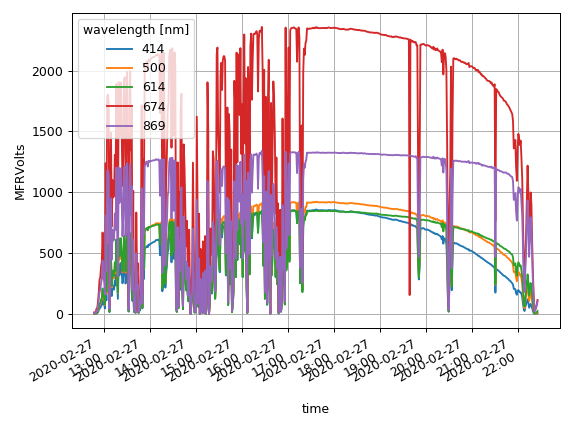

In [5]:
plt.figure()
dset.MFRVolts.plot.line(x="time");

<IPython.core.display.Javascript object>


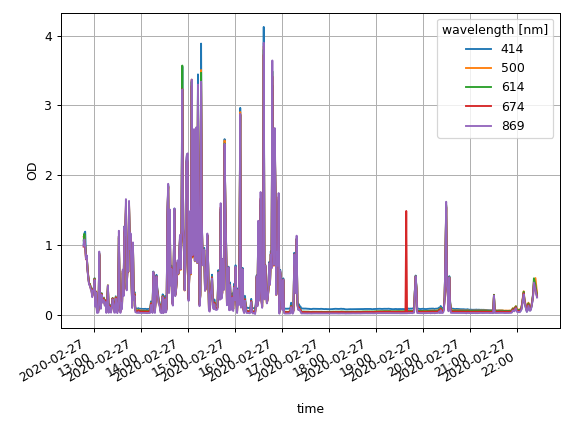

In [6]:
plt.figure()
dset.OD.plot.line(x="time");

<IPython.core.display.Javascript object>


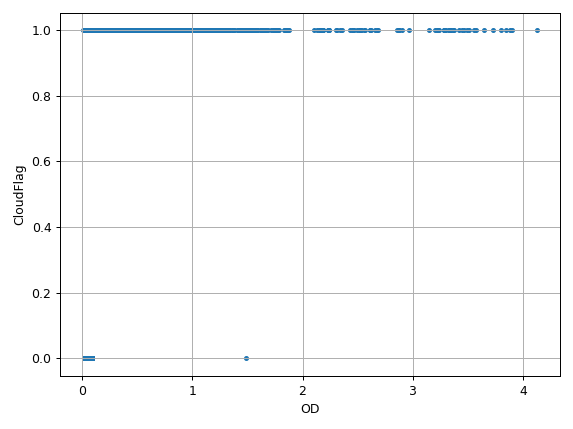

In [7]:
plt.figure()
dset.plot.scatter(x="OD", y="CloudFlag", marker=".");

^ we can see that there is one erroneous point that probably should have `CloudFlag = 0`

### Aeorsol-only optical depth using cloud mask

> 3) use the cloud mask to select just the aerosol optical depths
> 4) plot up the AODs with a legend to distinguish the plots

<IPython.core.display.Javascript object>


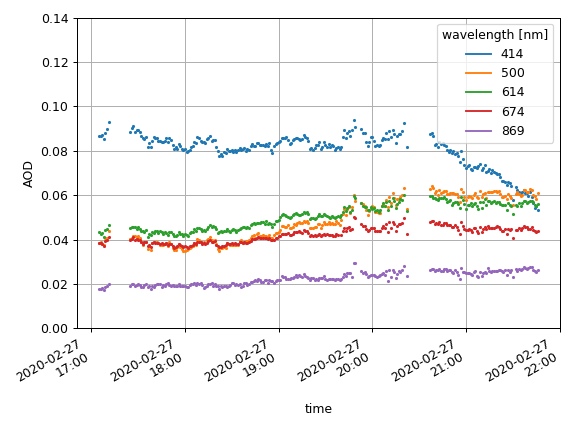

In [8]:
plt.figure()

# new variable "AOD" as "OD" with cloud not flagged
dset["AOD"] = dset.OD.where(dset.CloudFlag == 0) 

lines = dset.AOD.plot.line(x="time");
plt.ylim(ymin=0, ymax=0.14)  # to match Whiteman's figure

# we get a big spike if we leave as a line plot
plt.setp(lines, ls="", marker=".", ms=3);
    
# note: `dset.AOD.where(dset.CloudFlag == 0).plot.line(x="phony_dim_1", marker="*", linestyle="")`
# also works but doesn't auto-hide the point at ~ 1.5
# xr.plot.scatter is for plotting multiple variables against each other

### Competition entry

Remaking the plot *starting from the loading step* in as few chars as possible. This should be a standalone script, meaning in Python that we need to include the `import`s. 

Whiteman's for this (234 chars) doesn't have ax labels or a legend but does use the `MFRTime` var as x.

In IPython we have a list of the input cells called `In`, which we can use to count the chararacters:

In [9]:
def char_count(s):
    from IPython.display import display, Markdown    
    
    # remove lines with magic commands (these are not part of the code)
    lines = [line for line in s.split("\n") if line and line.strip()[0] != "%"]
    s = "".join(lines)  # don't need newline chars
    
    c_ = len(s)
    c_ns = len([c for c in s if not c.isspace()])  # exclude spaces
        
    # `;` at end is just to suppress output, not strictly part of the code
    c = c_ns - 1 if s.rstrip()[-1] == ";" else c_ns

    # `plt.figure()` is only necessary in this setting 
    # because xarray.plot default behavior is to plot in fig if it exists
    # in other settings it would not be necessary
    len_newfig = len("plt.figure()")
    c_mnf = c - len_newfig if "plt.figure" in s else c
    
    display(Markdown(
        f"including spaces: **{c_}**\n\n"
        f"non-space char count: **{c_ns}**\n\n"
        f"excluding IPython output suppression: **{c}**\n\n"
        f"excluding fresh fig command: **{c_mnf}**"
    ))


def char_count_previous_cell():
    # !important: only works if the nb is executed in order
    # e.g., restart and run all cells
    previous_In = In[-2]  # a special IPython list
    char_count(previous_In)

#### Completely standalone

In [10]:
%%writefile load_plot_h5.py

import matplotlib.pyplot as plt
import xarray as xr

d, c, t = xr.open_dataset("Ret_677_20200227v0.9.h5")[["AOD", "CloudFlag", "MFRTime"]].to_array()
plt.plot(t.T, d.where(c == 0).T, ".")
plt.show()

Overwriting load_plot_h5.py


This magic command would work properly if we weren't using `%matplotlib notebook` mode (i.e., `%matplotlib inline` instead). 
```ipython
%run load_plot_h5.py
```
For some reason, on first run of the Notebook in `%matplotlib notebook` mode, running the script creates an additional empty figure. Upon additional runs of that cell, though, it does not. 

Running the script on the command line, 
```sh
python load_plot_h5.py
```
produces the figure:
![The competition figure](./load_plot_h5_Figure_1.png)

(You'll just have to take my word for it.)

In [11]:
# count chars in the file
with open("load_plot_h5.py", "r") as f:
    char_count(f.read())

including spaces: **193**

non-space char count: **177**

excluding IPython output suppression: **177**

excluding fresh fig command: **177**

⬆ `plt.show()` (10 chars) is not necessary in the Notebook/IPython with `%matplotlib` mode (as we have seen) but is needed in a script if you want to be able to run with `python ...` at the command line. Note that in a real standalone script we don't need a new fig command because there is only one figure in the script. 

#### Within Notebook context

Of course, we can get a nicer plot with small char count using the `dset` that has coordinate variables set. But this doesn't include the `import` statements, loading the data, or the manipulations of the dataset representation that we made above. 

<IPython.core.display.Javascript object>


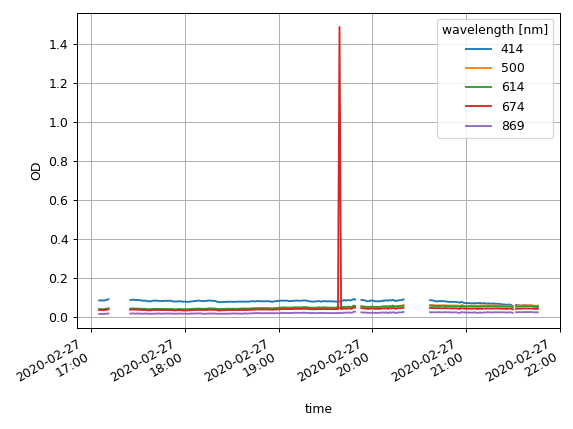

In [12]:
plt.figure()
dset.OD.where(dset.CloudFlag == 0).plot.line(x="time");

In [13]:
char_count_previous_cell()

including spaces: **67**

non-space char count: **65**

excluding IPython output suppression: **64**

excluding fresh fig command: **52**

### Ångström coefficient

> 5) compute the Ångström coefficient between the 414 and 869 nm wavelengths

could show solving the equation with SymPy like Whiteman has done with Wolfram?

<IPython.core.display.Javascript object>


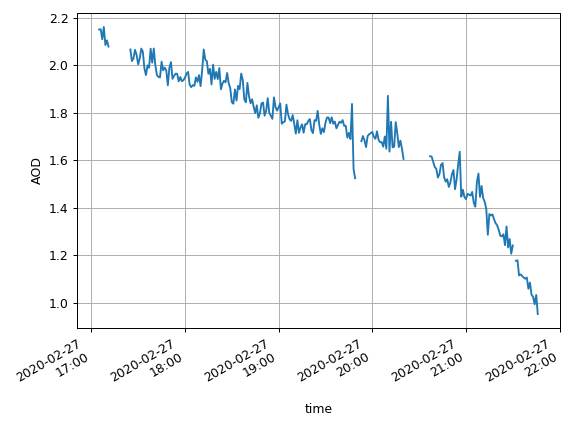

In [14]:
Ang414869 = -np.log(dset.AOD.sel(wavelength=414) / dset.AOD.sel(wavelength=869)) / np.log(414/869)
plt.figure()
Ang414869.plot();

## Exercise 2 (ASCII and netCDF radiosonde data file import and manipulation).


RS41 file is in this public Dropbox folder:  
https://www.dropbox.com/sh/4j2rvwbdbr0bgcw/AADrK7PCjInM0E7dfThEvtnBa/RS41?dl=0&lst=&subfolder_nav_tracking=1

RS92:  
https://www.dropbox.com/sh/4j2rvwbdbr0bgcw/AADYhzLJ9WsAWtSLB83X4Tlwa/RS92?dl=0&lst=&subfolder_nav_tracking=1

GRUAN process RS92:  
https://www.dropbox.com/sh/4j2rvwbdbr0bgcw/AAD7XhFPeyOol84fmu86Gw4pa/GRUAN?dl=0&lst=&subfolder_nav_tracking=1







> 4) calculate water vapor mixing ratio using the Hyland Wexler, 1983 definition of saturation vapor
pressure

> 5) compare some measurements between the RS92 and the GRUAN-processed RS92


### Load and inspect the data

> 1) view the ascii files to discern the formats

> 2) import the data

In [15]:
varnames = ["time", "temp", "rh", "height", "press", "mixrat"]
columns = [0, 2, 3, 6, 7, 9]
# ^ same in the RS92 file

rs41 = pd.read_table("HUBV_RS41SGP_20200123_064641UT.mw41.dat", 
                     names=varnames, skiprows=40, sep="\s+", usecols=columns)
rs41

,time,temp,rh,height,press,mixrat
0,0.00,268.37,85.00,52.3,1023.19,2.22
1,0.81,268.46,83.38,54.5,1022.90,2.19
2,1.81,268.74,81.17,59.8,1022.22,2.18
3,2.81,269.39,77.76,65.8,1021.44,2.20
4,3.81,270.30,73.57,72.1,1020.61,2.23
...,...,...,...,...,...,...
5301,5300.81,221.39,0.59,32725.2,7.27,0.03
5302,5301.81,221.38,0.59,32729.0,7.26,0.03
5303,5302.81,221.38,0.59,32741.6,7.25,0.03
5304,5303.81,221.37,0.59,32746.3,7.25,0.03


In [16]:
rs92 = pd.read_table("ALVICE_RS92SGP_20200123_064640UT.mw41.dat", 
                     names=varnames, skiprows=40, sep="\s+", usecols=columns)
rs92

,time,temp,rh,height,press,mixrat
0,0.00,268.37,85.00,53.0,1023.19,2.2200
1,1.45,268.70,83.90,57.7,1022.58,2.2500
2,2.45,269.12,82.90,60.9,1022.16,2.2900
3,3.45,269.77,81.20,65.4,1021.58,2.3600
4,4.45,270.51,79.00,71.4,1020.81,2.4300
...,...,...,...,...,...,...
5305,5305.63,221.37,1.02,32585.7,7.44,0.0433
5306,5306.63,221.40,1.03,32588.3,7.44,0.0437
5307,5307.63,221.42,1.04,32591.0,7.43,0.0443
5308,5308.63,221.42,1.06,32593.4,7.43,0.0452


In [17]:
# These dataset representations are long. Let's make a toggler.
def repr_toggle(variable):
    from IPython.core.display import display, HTML
    var_repr = variable._repr_html_() if hasattr(variable, "_repr_html_") else f"<pre>{repr(variable)}</pre>"
    display(HTML(f"""
<details>
  <summary style="display: list-item;">Toggle to see full repr</summary>

{var_repr}
</details>
    """.strip()))

In [18]:
gruan_all = xr.open_dataset("BEL-RS-01_2_RS92-GDP_002_20200123T064600_1-003-001.nc")
repr_toggle(gruan_all)

In [19]:
# pull out the variables we are going to use
gruan = gruan_all[["time", "temp", "rh", "geopot", "press", "WVMR"]]
# ^ could rename to have the same names used for the others
repr_toggle(gruan.variables)

### Sonde comparison

> 3) compare some measurements between the RS92 and RS41

<IPython.core.display.Javascript object>


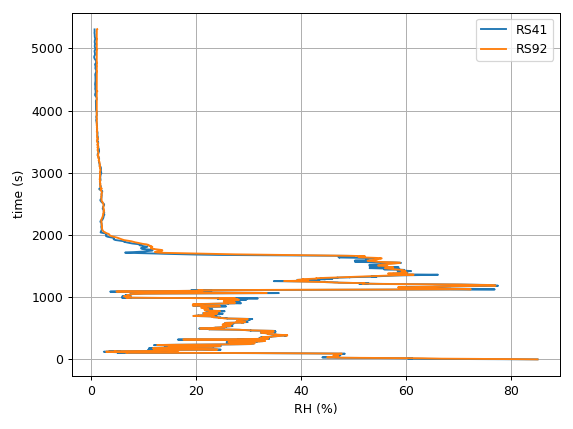

In [20]:
datasets = {
    "RS41": rs41,
    "RS92": rs92,
    #"GRUAN": gruan,
}

plt.figure()

for dsname, ds in datasets.items():
    plt.plot(ds["rh"], ds["time"], label=dsname)

plt.xlabel("RH (%)")
plt.ylabel("time (s)")

plt.legend();

In [21]:
# interpolate so we can regress
y_ = rs92["rh"]  # has its own time values, not same as the RS41
f = interpolate.interp1d(rs92["time"], rs92["rh"])  # x, y
y = f(rs41["time"])

x = rs41["rh"]
X = sm.add_constant(x)

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.183e+06
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:36:14   Log-Likelihood:                -8664.1
No. Observations:                5306   AIC:                         1.733e+04
Df Residuals:                    5304   BIC:                         1.735e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2420      0.021     11.786      0.000       0.202       0.282
rh             0.9995      0.001   1087.553      0.000       0.998       1.001
==============================================================================
Omnibus:                     4153.454   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162545.907
Skew:                           3.408   Prob(JB):                         0.00
Kurtosis:                      29.245   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#sm.graphics.plot_fit(res, 1);  # auto plot doesn't show the params

<IPython.core.display.Javascript object>


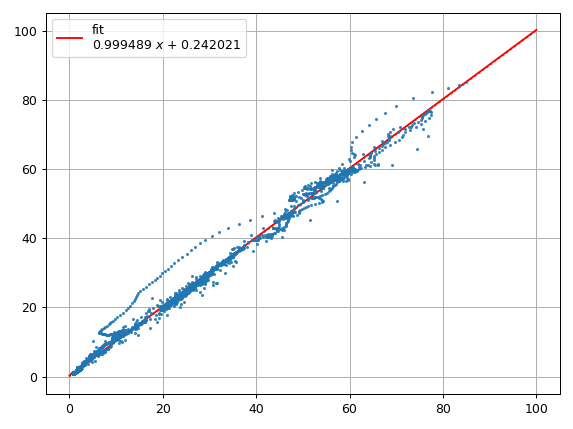

In [23]:
# manual plot
p = res.params  # 'const' and 'rh'

plt.figure()

plt.plot([0, 100], [0, 100], ":", c="0.5")

xfit = np.r_[0, 100]
fitstr = f"{p.rh:.6f} $x$ + {p.const:.6f}"
plt.plot(xfit, xfit*p.rh + p.const, c="r", label=f"fit\n{fitstr}")

plt.plot(x, y, '.', ms=3, alpha=0.8)

plt.legend();

### Water vapor mixing ratio

$$
\text{water vapor mixing ratio [g/kg]} = 10 \, \mathrm{RH} \, \cdot \varepsilon \frac{e_s}{p - \frac{\mathrm{RH}}{100} e_s}
$$

where $\varepsilon \approx 0.622$ is the ratio of water vapor molecular weight to dry air molecular weight.

In [24]:
def e_sat_Wexler(TempK):
    """Wexler formulation for saturation vapor pressure (over liquid)."""
    #TempK = TempC + 273.15

    return np.exp(
        -2.9912729e3 * TempK**-2 
        - 6.0170128e3 * TempK**-1 
        + 1.887643854e1 
        - 2.8354721e-2 * TempK 
        + 1.7838301e-5 * TempK**2 
        - 8.4150417e-10 * TempK**3 
        + 4.4412543e-13 * TempK**4 
        + 2.858487 * np.log(TempK)
    ) * 10. / 1000.

def mrw_Wexler(p, TempK, RH):
    """Water vapor mixing ratio using Wexler saturation VP over liquid."""
    e_s = e_sat_Wexler(TempK)
    
    return 10 * RH * 0.62197 * e_s / (
        p - RH/100 * e_s
    )

#### Manual Wexler calculation vs Vaisala

Compare our water vapor mixing ratio calculation with the one reported by the Vaisala sonde. 

<IPython.core.display.Javascript object>


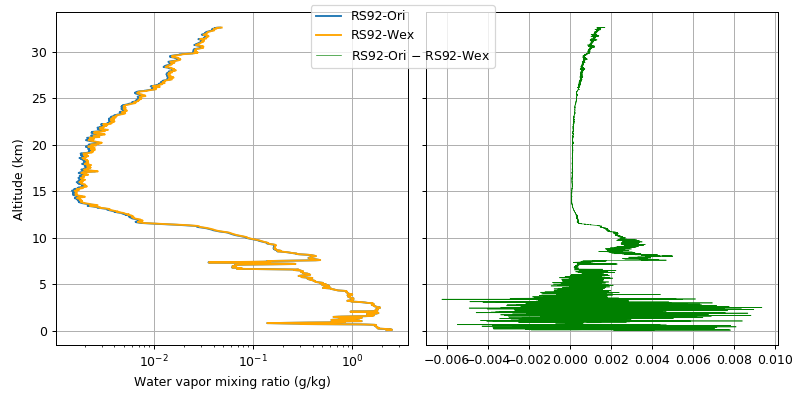

In [25]:
mrw_manual = mrw_Wexler(rs92["press"], rs92["temp"], rs92["rh"])

z = rs92["height"] / 1000  # m -> km

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(9, 4.5))

ax1.plot(rs92["mixrat"], z, label="RS92-Ori")
ax1.plot(mrw_manual, z, c="orange", label="RS92-Wex")
ax1.set_xscale("log")
#ax1.legend()

ax2.plot(mrw_manual - rs92["mixrat"], z, lw=0.5, c="green", label="RS92-Ori $-$ RS92-Wex")

ax1.set_xlabel("Water vapor mixing ratio (g/kg)")
ax1.set_ylabel("Altitude (km)")
#ax2.set_xlabel("")

fig.legend(loc="upper center");
fig.tight_layout();

> Exercise for the student!! Play around with the different vapor pressure
formulations and see if you can resolve the discrepancies shown in the plot
above. You may want to plot the data up differently to illustrate the
discrepancy between the two mixing ratio calculations.

We can find which one minimizes the difference wrt. GRUAN. 
* probably want to include using an ice one at lower temperature to be really the best? but when is it safe to assume the water would be frozen?
  - this probably doesn't matter since we are just trying to minimize the different wrt. Vaisala's value

#### Vaisala vs GRUAN

compare the normal RS92 file and the one generated using the
GRUAN data processing

<IPython.core.display.Javascript object>


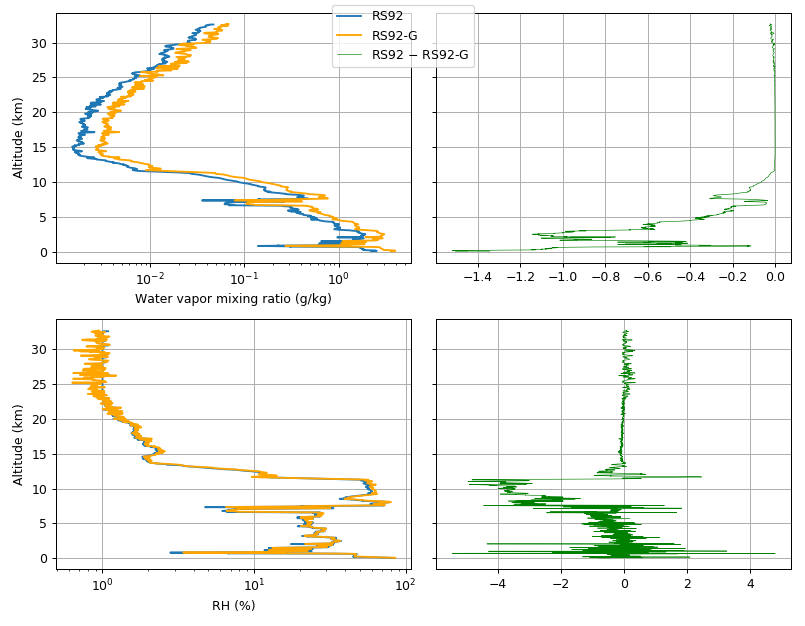

In [26]:

# gruan RH is in [0,1] not %
# gruan WVMR is in kg/kg not g/kg

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, sharey=True, figsize=(9, 7))

l1, = ax1.plot(rs92["mixrat"], rs92["height"]/1000, label="RS92")
l2, = ax1.plot(gruan["WVMR"]*1000, gruan["geopot"]/1000, c="orange", label="RS92-G")
ax1.set_xscale("log")

#ax2.plot(rs92["mixrat"] - gruan["WVMR"], z, lw=0.5, c="green", label="RS92 $-$ RS92-G")
ax3.plot(rs92["rh"], rs92["height"]/1000, label="RS92")
ax3.plot(gruan["rh"]*100, gruan["geopot"]/1000, c="orange", label="RS92-G")
ax3.set_xscale("log")

# interpolate one of them so we can subtract
# neglect any geopotential vs actual height difference that may exist here

# gruan time is loaded as datetime
t_gruan_elapsed = (gruan["time"] - gruan["time"][0])/np.timedelta64(1, "s")

f = interpolate.interp1d(rs92["time"], rs92["rh"])  # x, y
rs92_rh_new = f(t_gruan_elapsed)
f = interpolate.interp1d(rs92["time"], rs92["mixrat"])
rs92_mixrat_new = f(t_gruan_elapsed)

l3, = ax2.plot(rs92_mixrat_new - gruan["WVMR"]*1000, gruan["geopot"]/1000, "g", lw=0.5, 
         label="RS92 $-$ RS92-G")

ax4.plot(rs92_rh_new - gruan["rh"]*100, gruan["geopot"]/1000, "g", lw=0.5)


ax1.set_xlabel("Water vapor mixing ratio (g/kg)")
ax3.set_xlabel("RH (%)")

for ax in [ax1, ax3]:
    ax.set_ylabel("Altitude (km)")

fig.legend(loc="upper center", handles=[l1, l2, l3]);

⬆ The dry bias correction applied by GRUAN is clear looking at the log plot of water vapor mixing ratio. From the difference plot, it seems like it most pronounced in the lower troposphere. 

> Exercise for the student! Present the data in different ways to quantify the
magnitude of the dry bias correction. How much is the correction a function of
RH? How much is it a function of temperature?